The fitting tools have been updated in `fitting.py` to unify the way that the `MultiBeam` or drizzled stacks are fit.

**This requires the development branch "clean_fit_outputs"** (https://github.com/gbrammer/grizli/tree/clean_fit_outputs).  To check out that branch, use the following in the grizli repo directory

    git checkout -b clean_fit_outputs origin/clean_fit_outputs

In [1]:
%matplotlib inline

In [2]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli

No TEAL-based tasks available for this package!
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


FLT pre-processing done in WFC3IR_Reduction.ipynb of the ERS grism data

In [3]:
os.chdir('Prep') # Maybe necessary depending on where the notebook is run

all_grism_files = ['ib6o21qmq_flt.fits', 'ib6o21qoq_flt.fits', 'ib6o21r6q_flt.fits', 'ib6o21r8q_flt.fits', 
                   'ib6o23rsq_flt.fits', 'ib6o23ruq_flt.fits', 'ib6o23ryq_flt.fits','ib6o23s0q_flt.fits']

grp = grizli.multifit.GroupFLT(grism_files=all_grism_files, direct_files=[], 
              ref_file='../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits',
              seg_file='../Catalog/ERS_GOODS-S_IR.seg.fits',
              catalog='../Catalog/ERS_GOODS-S_IR.cat',
              cpu_count=8)

Load ib6o21qmq.01.GrismFLT.fits!
Load ib6o21qoq.01.GrismFLT.fits!
Load ib6o21r6q.01.GrismFLT.fits!
Load ib6o21r8q.01.GrismFLT.fits!
Load ib6o23rsq.01.GrismFLT.fits!
Load ib6o23ruq.01.GrismFLT.fits!
Load ib6o23ryq.01.GrismFLT.fits!
Load ib6o23s0q.01.GrismFLT.fits!
Files loaded - 14.23 sec.


Now provide two ways of saving the extracted 2D spectra of a given object:  "beams" cutouts from the FLT files and drizzled combinations of them, combined for the available grisms separately and for combinations of the available PAs.

ers-grism_40776.beams.fits


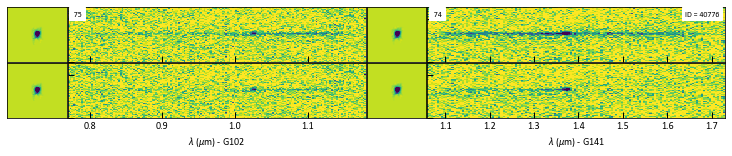

In [4]:
# grp `GroupFLT` object created as defined in WFC3IR_Reduction from the WFC3 ERS grism data
target = 'ers-grism'

# Line-emitter
id=40776

# Pull out the 2D cutouts
beams = grp.get_beams(id, size=80)
mb = grizli.multifit.MultiBeam(beams, fcontam=0.5, group_name=target, psf=False)

# Save a FITS file with the 2D cutouts (beams) from the individual exposures
mb.write_master_fits()

# Drizzle grisms / PAs
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.5, flambda=False, kernel='point', size=32)

# Save drizzle figure FITS file
fig.savefig('{0}_{1:05d}.stack.png'.format(target, id))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(target, id), clobber=True)

In [5]:
# Fitting templates
templ0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, stars=False, full_line_list=None, 
                                 continuum_list=None, fsps_templates=False)
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False, full_line_list=None, 
                                 continuum_list=None, fsps_templates=False)

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
print('templ0: ', list(templ0.keys()), '\n')

# Second set has individual line templates for fitting the line fluxes
print('templ1: ', list(templ1.keys()))

# Parameters for drizzled line maps
pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}

templ0:  ['eazy_intermediate.dat', 'cvd12_t11_solar_Chabrier.dat', 'post_starburst.dat', 'erb2010_continuum.dat', 'line Ha+NII+SII+SIII+He', 'line OIII+Hb', 'line OII+Ne', 'line Lya+CIV'] 

templ1:  ['eazy_intermediate.dat', 'cvd12_t11_solar_Chabrier.dat', 'post_starburst.dat', 'erb2010_continuum.dat', 'line PaB', 'line HeI-1083', 'line SIII', 'line SII', 'line Ha', 'line OI-6302', 'line OIII', 'line Hb', 'line OIII-4363', 'line Hg', 'line Hd', 'line NeIII', 'line OII', 'line NeVI', 'line NeV', 'line MgII', 'line CIV-1549', 'line CIII-1908', 'line OIII-1663', 'line HeII-1640', 'line NIII-1750', 'line NIV-1487', 'line NV-1240', 'line Lya']


Load file ers-grism_40776.stack.fits
Mask 0 additional pixels for ext G102,75.0
Mask 0 additional pixels for ext G141,74.0
1 ib6o21qmq_flt.fits G102
2 ib6o21qoq_flt.fits G102
3 ib6o21r6q_flt.fits G102
4 ib6o21r8q_flt.fits G102
5 ib6o23rsq_flt.fits G141
6 ib6o23ruq_flt.fits G141
7 ib6o23ryq_flt.fits G141
8 ib6o23s0q_flt.fits G141
Drizzle line -> OIII (15.13 0.99)
Drizzle line -> Hb   (3.46 0.83)
Drizzle line -> OII  (9.30 1.12)


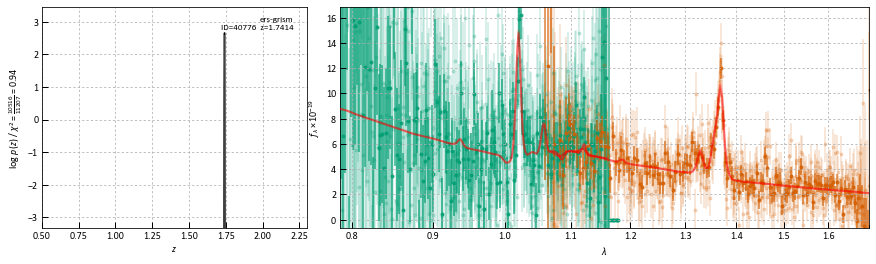

In [6]:
# High-level wrapper script for doing everything (redshift fits, line fluxes, drizzled line maps)
# More explanation of the details of individual steps TBD.
#
# Needs to be able to find {target}_{id:05d}.beams.fits and {target}_{id:05d}.stack.fits generated above
out = grizli.fitting.run_all(id, t0=templ0, t1=templ1, fwhm=1200, zr=[0.5, 2.3], dz=[0.004, 0.0005], 
                             fitter='nnls', group_name=target, prior=None, fcontam=0.2,
                             pline=pline, mask_sn_limit=10, fit_beams=True, fit_stacks=False,  
                             root=target+'_', fit_trace_shift=False, verbose=False, 
                             phot=None, scale_photometry=False, show_beams=True)

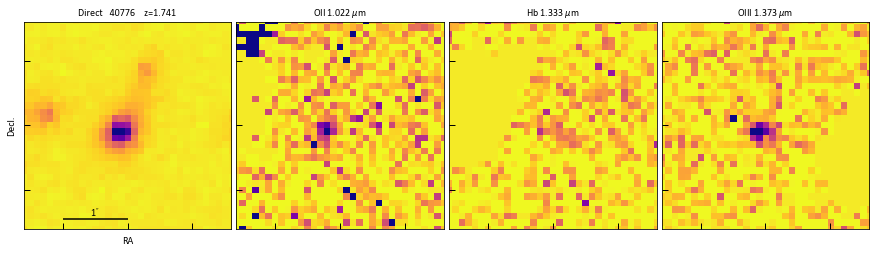

In [7]:
# Show the drizzled line maps
line_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(target, id))
fig = grizli.fitting.show_drizzled_lines(line_hdu, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(target, id))